In [25]:
# filename: knn.ipynb
# purpose: knn model implement

# OHT KNN model implement

### KNN implements
- KNN classification method will be used to detect abnormal,outlier data

### Processing flow
- Read mixed dataset from dukdb table
- Reduce dataset to the required volumn
- Convert int label in flag column to str label for easier understaing of the classification report
- Split training and test dataset and labels
- Search best-K value in the configured neighbor range 
- KNN train with the searched best K value 
- Predict with test dataset
- Report the prediction report with best-K, accuracy score, confusion matrix (precision,recall,f-score,support)
- Chart confunsion matrix by heatmap
- Chart decision boundary scatter with 2 features
  

In [26]:
# packages
import time
import os
import pathlib
import tempfile
import numpy as np
import pandas as pd

import humanfriendly as human

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

# Plotting decision boundaries
from matplotlib.colors import ListedColormap

import ohtconf as conf
import ohtcomm as comm

## Main

In [27]:
mainstart = time.time()

In [28]:
USESCALE = False  # no big difference between feature scaling or not

In [29]:
# read table data
_start = time.time()

dfmix = comm.read_tabdf(conf.TABNAME_MIX)
dfmix.sort_values(by=conf.COLUMN_NAMES[0], inplace=True)
dfmix.reset_index(drop=True, inplace=True)

dfknn = dfmix.iloc[0 : conf.TRAIN_SIZE]  # execution time key factor

# type convert to prevent model fit, RuntimeWarning: invalid value encountered in cast
for col in conf.COLUMN_GRAPH:
    if col in conf.COLUMN_PMA + conf.COLUMN_COA:
        dfknn[col] = dfknn[col].astype(np.float32)

print(f"row count, mix={len(dfmix)}, knn={len(dfknn)}, expected knn={conf.TRAIN_SIZE}")

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

row count, mix=108000, knn=108000, expected knn=800000
elapsed time: 0.11 seconds


### Common functions

In [30]:
def make_strlabel(ay: pd.Series, intlabels: list[int] | None = None, strlabels: list[str] | None = None) -> pd.Series:
    """map int labels to str labels

    map values (0~10) to (NORM,TEM,...,CT3)
    """
    if intlabels is None or strlabels is None:
        all_columns = conf.COLUMN_GRAPH
        intlabels = list(range(0, 11))  # 0 ~ 10 for normal, outlier-tem,...,outlier-ct4 flag
        strlabels = ["NORM"] + all_columns  # NORM for normal, others are for outlier

    label_dict = {i: s for i, s in zip(intlabels, strlabels)}
    ay = ay.map(label_dict)
    return ay

In [31]:
def make_intlabel(ay: pd.Series, strlabels: list[str] | None = None, intlabels: list[int] | None = None) -> pd.Series:
    """map str labels to int labels

    map values (NORM,TEM,...,CT3) to (0~10)
    """
    if intlabels is None or strlabels is None:
        all_columns = conf.COLUMN_GRAPH
        intlabels = list(range(0, 11))  # 0 ~ 10 for normal, outlier-tem,...,outlier-ct4 flag
        strlabels = ["NORM"] + all_columns  # NORM for normal, others are for outlier

    label_dict = {s: i for s, i in zip(strlabels, intlabels)}
    ay = ay.map(label_dict)
    return ay

In [32]:
def knn_train(
    X: pd.DataFrame, y: pd.Series, columns: list[str], labels: list[str]
) -> tuple[int, KNeighborsClassifier, pd.DataFrame, pd.Series]:
    """knn modle training"""

    def do_x_scale(ax: pd.DataFrame, acolumns: list[str]) -> pd.DataFrame:
        """standardize feature values"""
        if USESCALE:
            scaler = StandardScaler()
            ax = pd.DataFrame(scaler.fit_transform(ax), columns=acolumns)
        return ax

    def do_grid_search(xtrain: pd.DataFrame, ytrain: pd.Series) -> GridSearchCV:
        """grid search for the best k value"""
        _start = time.time()
        knn = KNeighborsClassifier()  # Create KNN classifier
        param_grid = {"n_neighbors": conf.N_NEIGHBORS}  # Grid search for optimal K value
        print(f"param_grid={param_grid}")

        # K-fold Cross-Validation: Divide the dataset into K folds. Train the model on K-1 folds and evaluate on the remaining fold.
        # Repeat this K times, rotating the validation fold.
        gsearch = GridSearchCV(knn, param_grid, cv=4, verbose=3)  # cv for cross validator folds
        gsearch.fit(xtrain, ytrain)

        _elapsed = time.time() - _start
        print(f"do_grid_search elapsed time: {human.format_timespan(_elapsed)}")
        return gsearch

    def do_knn_train(xtrain: pd.DataFrame, ytrain: pd.Series, best_k: int) -> KNeighborsClassifier:
        _start = time.time()
        # model with best K
        amodel = KNeighborsClassifier(n_neighbors=best_k)
        amodel.fit(xtrain, ytrain)
        _elapsed = time.time() - _start
        print(f"do_knn_train elapsed time: {human.format_timespan(_elapsed)}")
        return amodel

    #
    _start = time.time()

    # x scaling
    if USESCALE:
        X = do_x_scale(X, columns)

    # split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% test set

    # search best_k by using grid serarch
    gridsearch = do_grid_search(X_train, y_train)
    best_k = gridsearch.best_params_["n_neighbors"]

    # knn train with best_k
    model = do_knn_train(X_train, y_train, best_k)

    _elapsed = time.time() - _start
    print(f"knn_train elapsed time: {human.format_timespan(_elapsed)}")

    return best_k, model, X_test, y_test

In [33]:
def knn_predict(amodel: KNeighborsClassifier, xtest: pd.DataFrame) -> pd.Series:
    # predictions
    ypred = model.predict(xtest)
    return ypred

In [34]:
def knn_report(bestk: int, ytest: pd.Series, ypred: pd.Series, labels: list[str], title: str) -> pd.DataFrame:
    print(f"\n*** Start of KNN modeling report for {title} ***\n")

    # best_k
    print(f"\nBest K = {bestk} on the evaluated range={conf.N_NEIGHBORS}")

    # Accuracy score = (TP + TN) / (TP + TN + FP + FN)
    accuracy = accuracy_score(ytest, ypred)
    print("\nAccuracy Score = ", accuracy)

    # Confusion Matrix
    #                   Predicted Positive	Predicted Negative
    # Actual Positive	True Positive (TP)	False Negative (FN)
    # Actual Negative	False Positive (FP)	True Negative (TN)

    cm = confusion_matrix(ytest, ypred, labels=labels)
    dfcm = pd.DataFrame(cm, index=labels, columns=labels)
    print("\nConfusion Matrix :\n", dfcm)

    # Classification Report
    # Precisoin = TP / (TP + FP)
    # Recall (Sensitivity) = TP / (TP + FN)
    # F1 Score = 2 * (Precision x Recall) / (Precision + Recall)
    # Support - instances of class in the dataset

    report = classification_report(ytest, ypred, labels=labels)
    print("\nClassification Report :\n", report)

    print(f"\n*** End of KNN modeling report for {title} ***\n")

    return dfcm

In [35]:
def knn_cm_heatmap(dfcm: pd.DataFrame, title: str, pngfile: str) -> None:
    """knn confusion matrix heatmap

    A confusion matrix helps you understand the performance of the classification algorithm by showing the true vs. predicted labels
    """
    fig, ox = plt.subplots(nrows=1, ncols=1, figsize=conf.PLOTSIZE)
    sns.heatmap(dfcm, annot=True, cmap="coolwarm", linewidths=0.5, fmt="d", ax=ox)
    # ox.xaxis.tick_top()
    # ox.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ox.set_xlabel("Predicted", labelpad=15)
    ox.set_ylabel("Actual")

    fig.suptitle(f"Confusion Matrix of {title}")

    plt.tight_layout()
    plt.show()

    if pngfile is not None:
        pngfile = pngfile.lower()
        filepath = pathlib.Path(conf.DIRCHART) / pngfile
        fig.savefig(
            filepath,
            dpi=conf.DPI,
            facecolor="w",
            edgecolor="w",
            orientation="portrait",
            format=None,
            transparent=False,
            bbox_inches=None,
            pad_inches=None,
        )

In [36]:
def knn_2fs_db_scatter(
    ax: pd.DataFrame, ay: pd.Series, amodel: KNeighborsClassifier, bestk: int, title: str, pngfile: str
):
    """knn 2 features decison boundary scatter

    This plot shows how the KNN algorithm classifies different regions of the feature space.
    """

    assert len(ax.columns) == 2, "knn_2feature_decision_boundary should have 2 features"

    # Create color maps
    light_colors = [
        "#FFDDC1",
        "#FFABAB",
        "#FFC3A0",
        "#FF677D",
        "#D4A5A5",
        "#392F5A",
        "#31A2AC",
        "#61C0BF",
        "#6B4226",
        "#D9BF77",
    ]
    bold_colors = [
        "#E6194B",
        "#3CB44B",
        "#FFE119",
        "#4363D8",
        "#F58231",
        "#911EB4",
        "#42D4F4",
        "#F032E6",
        "#BFEF45",
        "#FABED4",
    ]

    cmap_light = ListedColormap(light_colors)
    cmap_bold = ListedColormap(bold_colors)

    # Create a mesh grid for plotting decision boundaries
    x_add = 10 if ax.iloc[:, 0].max() / 100 >= 1 else 1
    y_add = 10 if ax.iloc[:, 1].max() / 100 >= 1 else 1
    x_min, x_max = ax.iloc[:, 0].min() - x_add, ax.iloc[:, 0].max() + x_add
    y_min, y_max = ax.iloc[:, 1].min() - y_add, ax.iloc[:, 1].max() + y_add

    # Predict the class for each point in the mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

    # np.c_[array,array] - translates slice objects to concatenation along the second axis. xx.ravel() - return flattened array,
    dfgrid = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=ax.columns)
    # print(f"type dfgrid={type(dfgrid)}, dfgrid={dfgrid.head()}")
    Z = amodel.predict(dfgrid)  # 1-d array
    Z = pd.Series(Z)  # convert to pd.Series to use map
    Z = make_intlabel(Z)  # predicted str label map to int label for using color map at pcolormesh()
    Z = Z.to_numpy()  # convert to 1-d array
    Z = Z.reshape(xx.shape)  # reshape

    # Plot also the training points
    fig, ox = plt.subplots(nrows=1, ncols=1, figsize=conf.PLOTSIZE)

    # print(f"type xx={type(xx)}, yy={type(yy)}, Z={type(Z)}"); print(f"valuex x={xx[:3]}, yy={yy[:3]} Z={Z[:3]}")
    ox.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    # c=y - sequence of n numbers to be mapped to colors using *cmap*
    yi = make_intlabel(ay)
    ox.scatter(ax.iloc[:, 0], ax.iloc[:, 1], c=yi, cmap=cmap_bold, edgecolor="k", s=10)
    # ox.xaxis.tick_top()
    # ox.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
    ox.set_xlim(xx.min(), xx.max())
    ox.set_ylim(yy.min(), yy.max())
    ox.set_xlabel(ax.columns[0])
    ox.set_ylabel(ax.columns[1])

    fig.suptitle(f"K={bestk} class classification of {title}")

    plt.show()

    if pngfile is not None:
        pngfile = pngfile.lower()
        filepath = pathlib.Path(conf.DIRCHART) / pngfile
        fig.savefig(
            filepath,
            dpi=conf.DPI,
            facecolor="w",
            edgecolor="w",
            orientation="portrait",
            format=None,
            transparent=False,
            bbox_inches=None,
            pad_inches=None,
        )

### KNN modeling with all 10 features

In [37]:
# knn training
_start = time.time()

# data  feature, column name and labels for flag column value
ALL_ILABELS = list(range(0, 11))  # 0 ~ 10 for normal, outlier-tem,...,outlier-ct4 flag
ALL_COLUMNS = conf.COLUMN_GRAPH
ALL_LABELS = ["NORM"] + ALL_COLUMNS  # NORM for normal, others are for outlier

# data
X = dfknn.loc[:, ALL_COLUMNS]

# label
y = dfknn.loc[:, [conf.COLUMN_FLAG]].copy()  # dataframe
y = y[conf.COLUMN_FLAG]  # series
y = make_strlabel(
    y, ALL_ILABELS, ALL_LABELS
)  # map y, number labels(0~10) to str labels (NORM,TEM,...,CT3) for easier report understanding

best_k, model, X_test, y_test = knn_train(X, y, ALL_COLUMNS, ALL_LABELS)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': range(2, 9)}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END .....................n_neighbors=2;, score=0.975 total time=   1.2s
[CV 2/4] END .....................n_neighbors=2;, score=0.977 total time=   1.3s
[CV 3/4] END .....................n_neighbors=2;, score=0.976 total time=   1.4s
[CV 4/4] END .....................n_neighbors=2;, score=0.976 total time=   1.3s
[CV 1/4] END .....................n_neighbors=3;, score=0.976 total time=   1.4s
[CV 2/4] END .....................n_neighbors=3;, score=0.977 total time=   1.3s
[CV 3/4] END .....................n_neighbors=3;, score=0.977 total time=   1.4s
[CV 4/4] END .....................n_neighbors=3;, score=0.977 total time=   1.4s
[CV 1/4] END .....................n_neighbors=4;, score=0.974 total time=   1.4s
[CV 2/4] END .....................n_neighbors=4;, score=0.976 total time=   1.4s
[CV 3/4] END .....................n_neighbors=4;, score=0.976 total time=   1.4s
[CV 4/4] 

In [38]:
# knn predict
_start = time.time()

y_pred = knn_predict(model, X_test)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 1.8 seconds


In [39]:
# knn report

dfcm = knn_report(best_k, y_test, y_pred, ALL_LABELS, title="all 10 features")


*** Start of KNN modeling report for all 10 features ***


Best K = 3 on the evaluated range=range(2, 9)

Accuracy Score =  0.9804166666666667

Confusion Matrix :
         NORM  TEM  PM1  PM2_5  PM10   CO  NH3  CT1  CT2  CT3  CT4
NORM   16132    2    0      0    11    1    6    3    0    3    5
TEM       19  491    5      3     3    0    4   11    0    0    4
PM1        7    0  473      4     7    0    3   10    0    0    8
PM2_5      8    2    6    484     4    0    8   11    2    1   12
PM10      31    1   10      8   476    0    8    9    0    1    4
CO        14    0    0      0     0  551    0    0    0    0    0
NH3       14    0    7      5    10    0  526    3    0    0    6
CT1       10    0    4      5     4    0    4  506    0    2    5
CT2       15    0    4      2     2    0    3    3  511    0    3
CT3       11    0    0      2     0    0    0    6    0  519    0
CT4       10    0    5      3     4    0    1   10    0    1  508

Classification Report :
               pre

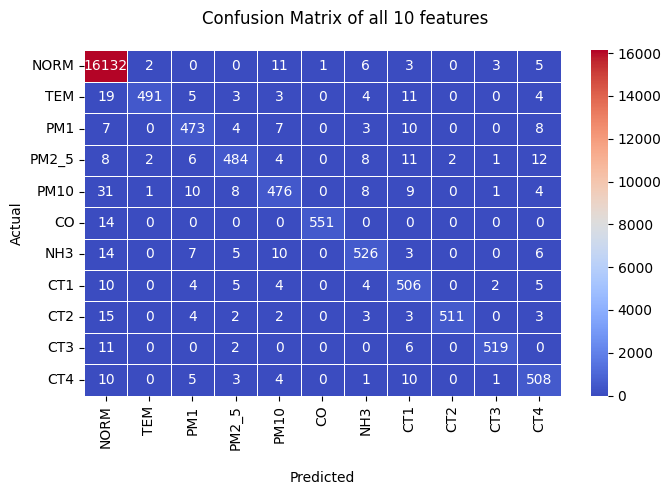

elapsed time: 2.63 seconds


In [40]:
# knn confusion matrix heatmap chart
start = time.time()

pngfile = "knn-cm-heatmap-all.png"
knn_cm_heatmap(dfcm, title="all 10 features", pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

### KNN trainned model usage example 
- save trainned model to a file by trainning program
- load the saved model by another predicting program
- do predicting

In [56]:
# Save model to a named temporary file
temp_joblib_file = None
with tempfile.NamedTemporaryFile(prefix="knn-model-all_", suffix=".joblib", dir=None, delete=False) as temp_file:
    joblib.dump(model, temp_file)
    temp_joblib_file = temp_file.name
    print(f"Temporary joblib file created: {temp_joblib_file}")

Temporary joblib file created: C:\Users\user\AppData\Local\Temp\knn-model-all_f94hmqyd.joblib


In [57]:
# Load the model from the file
load_model = joblib.load(temp_joblib_file)
print(f"Temporary joblib file loaded: {temp_joblib_file}")

load_test = X_test.iloc[0:1]
expect_y = y_pred[0:1]
print(f"load model test data:\n{load_test.to_string()}")

predict_y = knn_predict(load_model, load_test)
if predict_y[0] == expect_y[0]:
    print(f"loaded model predicted value match with expected value: {predict_y[0]}, {expect_y[0]}")
else:
    print(f"loaded model predicted value unmatch with expected value: {predict_y[0]}, {expect_y[0]}")

Temporary joblib file loaded: C:\Users\user\AppData\Local\Temp\knn-model-all_f94hmqyd.joblib
load model test data:
             TEM   PM1  PM2_5  PM10     CO   NH3  CT1  CT2  CT3  CT4
36349  40.599998  13.0   13.0  15.0  162.0  89.0  0.9  1.0  0.4  0.5
loaded model predicted value match with expected value: NORM, NORM


In [58]:
# Delete the model file
os.remove(temp_joblib_file)
print(f"Temporary joblib file deleted: {temp_joblib_file}")

Temporary joblib file deleted: C:\Users\user\AppData\Local\Temp\knn-model-all_f94hmqyd.joblib


### KNN modeling with 2 features for 2-D visualization 

In [19]:
_start = time.time()

# data  feature, column name and labels for flag column value
TWO_ILABELS = [0, 1, 6]  # 0 for normal, 1 for outlier-tem, 6 for outlier-nh3
TWO_COLUMNS = [conf.COLUMN_NAMES[TWO_ILABELS[1]], conf.COLUMN_NAMES[TWO_ILABELS[2]]]
TWO_LABELS = ["NORM"] + TWO_COLUMNS  # NORM for normal, other are for outlier

# data
X = dfknn.loc[:, TWO_COLUMNS]

# label
y = dfknn.loc[:, [conf.COLUMN_FLAG]].copy()  # dataframe
# clear non-candidate column's flag value
y.loc[(y[conf.COLUMN_FLAG] != TWO_ILABELS[1]) & (y[conf.COLUMN_FLAG] != TWO_ILABELS[2]), conf.COLUMN_FLAG] = 0
y = y[conf.COLUMN_FLAG]  # series
# map y, label values TWO_INDEXES to TWO_LABELS
y = make_strlabel(y, TWO_ILABELS, TWO_LABELS)

best_k, model, X_test, y_test = knn_train(X, y, TWO_COLUMNS, TWO_LABELS)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

param_grid={'n_neighbors': range(2, 9)}
Fitting 4 folds for each of 7 candidates, totalling 28 fits
[CV 1/4] END .....................n_neighbors=2;, score=0.977 total time=   2.1s
[CV 2/4] END .....................n_neighbors=2;, score=0.986 total time=   2.1s
[CV 3/4] END .....................n_neighbors=2;, score=0.986 total time=   2.1s
[CV 4/4] END .....................n_neighbors=2;, score=0.988 total time=   2.1s
[CV 1/4] END .....................n_neighbors=3;, score=0.987 total time=   2.1s
[CV 2/4] END .....................n_neighbors=3;, score=0.987 total time=   2.1s
[CV 3/4] END .....................n_neighbors=3;, score=0.986 total time=   2.2s
[CV 4/4] END .....................n_neighbors=3;, score=0.987 total time=   2.2s
[CV 1/4] END .....................n_neighbors=4;, score=0.987 total time=   2.1s
[CV 2/4] END .....................n_neighbors=4;, score=0.987 total time=   2.2s
[CV 3/4] END .....................n_neighbors=4;, score=0.986 total time=   2.1s
[CV 4/4] 

In [20]:
# knn predict
_start = time.time()

y_pred = knn_predict(model, X_test)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

elapsed time: 2.56 seconds


In [21]:
# knn report

dfcm = knn_report(best_k, y_test, y_pred, TWO_LABELS, title=" & ".join(TWO_COLUMNS))


*** Start of KNN modeling report for TEM & NH3 ***


Best K = 6 on the evaluated range=range(2, 9)

Accuracy Score =  0.9872222222222222

Confusion Matrix :
        NORM  TEM  NH3
NORM  20466   16    7
TEM     131  406    3
NH3     118    1  452

Classification Report :
               precision    recall  f1-score   support

        NORM       0.99      1.00      0.99     20489
         TEM       0.96      0.75      0.84       540
         NH3       0.98      0.79      0.88       571

    accuracy                           0.99     21600
   macro avg       0.98      0.85      0.90     21600
weighted avg       0.99      0.99      0.99     21600


*** End of KNN modeling report for TEM & NH3 ***



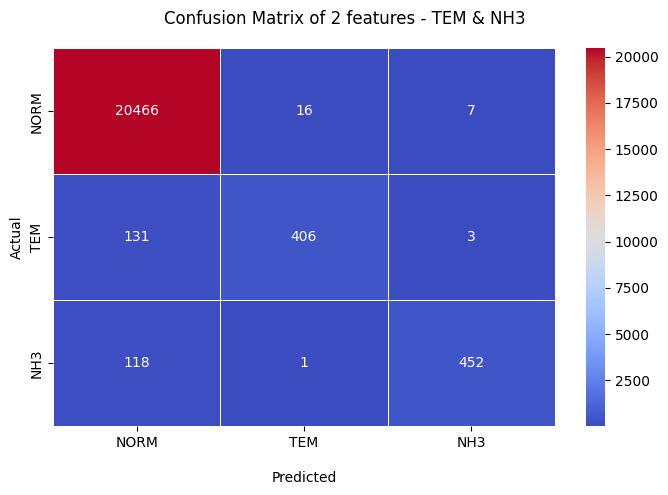

elapsed time: 3.13 seconds


In [22]:
# knn confusion matrix heatmap chart
start = time.time()

pngfile = f"knn-cm-heatmap-{'-'.join(TWO_COLUMNS)}.png"
knn_cm_heatmap(dfcm, title=f"2 features - {' & '.join(TWO_COLUMNS)}", pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

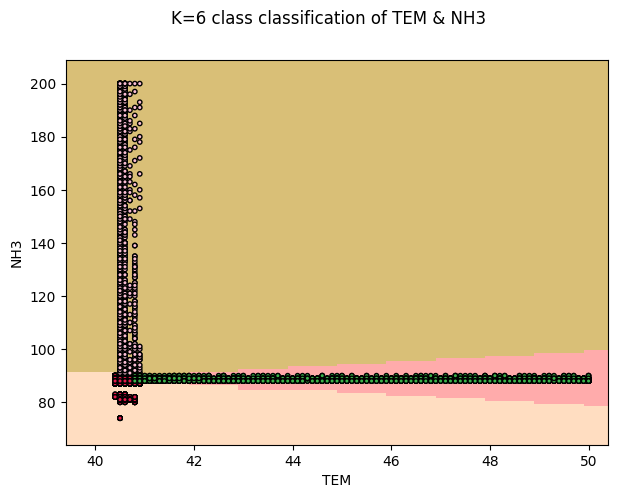

elapsed time: 5.44 seconds


In [23]:
# knn decision boundary scatter, 2-D visualization
start = time.time()

pngfile = f"knn-db-scatter-{'-'.join(TWO_COLUMNS)}.png"
knn_2fs_db_scatter(X, y, model, best_k, title=" & ".join(TWO_COLUMNS), pngfile=pngfile)

_elapsed = time.time() - _start
print(f"elapsed time: {human.format_timespan(_elapsed)}")

In [24]:
_elapsed = time.time() - mainstart
print(f"main elapsed time: {human.format_timespan(_elapsed)}")

main elapsed time: 4 minutes and 32.53 seconds
